In [1]:
# This notebook is for DUP evaluation
# I have developed skeleton code for the evaluation of DUP using LAST and HG2-T2T v0.9 data
# This notebook is for transition from HG2-T2T v0.9 to HG2-T2T v1.0 and LAST to minimap2
# Additionally, I want to incorporate evaluating DUP+DEL cases in T2T-ACE
# TODO: 1. Transit initial analyzing code for DUP evaluation to avoid repetitive code for the same function and add more functions specific to DUP evaluation DONE
# TODO: 2. Develop code for DUP+DEL evaluation DONE
# TODO: 3. Evaluate DUP+DEL cases DONE
# TODO: 4. Evaluate DUP+DEL cases that are not working as expected 12, 13


In [2]:
import warnings
warnings.filterwarnings( "ignore", module = "seaborn\..*" )
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
import T2T_ACE.alignment_utilities as au 
import T2T_ACE.validator as v
import T2T_ACE.alignment_visualization_utilities as avu
import importlib
import pandas as pd
import T2T_ACE.genomic_queries as gq
import T2T_ACE.interval_parsing as ip

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# Update the reference genomes to local path
class ReferenceLocations:
        hg002t2t = "/Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta"
        chm13 = "/Users/gaoyueya/Documents/Reference_Genome/chm13v2.0.fa.gz"
        hg38 = "/Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta"

In [4]:
# Load HG002 T2T reference
hg002t2t = au.load_reference(ReferenceLocations.hg002t2t)
# Load hg38 reference
hg38 = au.load_reference(ReferenceLocations.hg38)

INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/hg002v1.0.fasta
INFO:root:Loading reference from: /Users/gaoyueya/Documents/Reference_Genome/Homo_sapiens_assembly38.fasta


# DEL within DUP cases

In [26]:
HG2_DRAGEN_cnv_path = "/Users/gaoyueya/Documents/Projects/TAG-Ticket1639/DRAGEN4_2_4_visualization/DRAGEN_Output/NA24385.cnv_sv.vcf"
def read_vcf(vcf_path):
    df = pd.read_csv(vcf_path, comment='#', sep='\t', header=None, names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    return df

In [27]:
HG2_DRAGEN_cnv = read_vcf(HG2_DRAGEN_cnv_path)
HG2_DRAGEN_pass_cnv = HG2_DRAGEN_cnv[HG2_DRAGEN_cnv['FILTER']=='PASS']
HG2_DRAGEN_pass_cnv.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE
0,chr1,789481,DRAGEN:GAIN:chr1:789482-224014488,N,<DUP>,150,PASS,END=224014488;SVTYPE=DUP;SVLEN=223225007;CIPOS...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:602:652,0,663:11,5:33,21"
1,chr1,934321,DRAGEN:LOSS:chr1:934322-934937,N,<DEL>,150,PASS,END=934937;SVTYPE=DEL;SVLEN=-616;CIGAR=1M616D;...,GT:FT:GQ:PL:PR:SR,"1/1:PASS:55:924,58,0:1,2:0,24"
3,chr1,1934923,DRAGEN:LOSS:chr1:1934924-1935584,N,<DEL>,150,PASS,END=1935584;SVTYPE=DEL;SVLEN=-661;CIGAR=1M661D...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:503:553,0,707:24,1:38,18"
4,chr1,1934989,DRAGEN:LOSS:chr1:1934990-1935584,N,<DEL>,150,PASS,END=1935584;SVTYPE=DEL;SVLEN=-595;CIGAR=1M595D...,GT:FT:GQ:PL:PR:SR,"0/1:PASS:426:476,0,746:21,2:42,16"
5,chr1,2122128,DRAGEN:LOSS:chr1:2122129-2124374,N,<DEL>,150,PASS,"END=2124374;SVTYPE=DEL;SVLEN=-2246;CIPOS=0,10;...",GT:FT:GQ:PL:PR:SR,"0/1:PASS:556:606,0,635:34,2:21,20"


In [28]:
# Gather all the intervals for DEL and DUP from HG2 DRAGEN PASS
DEL_pass_intervals = []
DUP_pass_intervals = []
for index, row in HG2_DRAGEN_pass_cnv.iterrows():
    interval = row['CHROM'] + ':' + str(row['POS']) + '-' + str(row['INFO'].split('END=')[1].split(';')[0])
    if row['ALT'] == '<DEL>':
        DEL_pass_intervals.append(interval)
    elif row['ALT'] == '<DUP>':
        DUP_pass_intervals.append(interval)
print('HG2 DEL intervals:',len(DEL_pass_intervals))
print('HG2 DUP intervals:',len(DUP_pass_intervals))

HG2 DEL intervals: 996
HG2 DUP intervals: 115


In [29]:
# Remove the DUP interval that is a known FP
DUP_pass_intervals.remove("chr1:789481-224014488") 

In [108]:
# Collect all the DEL within DUP intervals
del_within_dup_list = []
dup_within_del_list = []
for del_interval in DEL_pass_intervals:
    del_chrom = del_interval.split(':')[0]
    del_pos = int(del_interval.split(':')[1].split('-')[0])
    del_end = int(del_interval.split(':')[1].split('-')[1])
    for dup_interval in DUP_pass_intervals: 
        dup_chrom = dup_interval.split(':')[0]
        dup_pos = int(dup_interval.split(':')[1].split('-')[0])
        dup_end = int(dup_interval.split(':')[1].split('-')[1])
        if del_chrom == dup_chrom:
            if del_pos >= dup_pos and del_end <= dup_end:
                print('DEL within DUP:', del_interval, dup_interval)
                del_within_dup_list.append([del_interval, dup_interval])
            elif dup_pos >= del_pos and dup_end <= del_end:
                print('DUP within DEL:', del_interval, dup_interval)
                dup_within_del_list.append([del_interval, dup_interval])

DEL within DUP: chr1:13235347-13240700 chr1:13225212-13247040
DEL within DUP: chr2:89815283-89817768 chr2:89795582-89851643
DEL within DUP: chr9:40902057-40902568 chr9:40867979-41021827
DEL within DUP: chr14:19907852-19911319 chr14:19725013-19956413
DEL within DUP: chr16:34176544-34178323 chr16:34163911-34184726
DEL within DUP: chr16:34182721-34183891 chr16:34163911-34184726
DUP within DEL: chr17:21984528-21988903 chr17:21986665-21987716
DEL within DUP: chr17:22139255-22143674 chr17:22130211-22156606
DEL within DUP: chr17:45613816-46277010 chr17:45578419-46289344
DUP within DEL: chr17:45613816-46277010 chr17:46205463-46208952
DEL within DUP: chr17:46237501-46238225 chr17:45578419-46289344
DEL within DUP: chr17:46237501-46238225 chr17:46135409-46292238
DEL within DUP: chr17:46237501-46238225 chr17:46135409-46282220
DEL within DUP: chr17:46277763-46282220 chr17:45578419-46289344
DEL within DUP: chr17:46277763-46282220 chr17:46135409-46292238
DEL within DUP: chr17:46277763-46282220 chr17:

In [107]:
print('HG2 DEL within DUP:', len(del_within_dup_list))
print('HG2 DUP within DEL:', len(dup_within_del_list))

HG2 DEL within DUP: 17
HG2 DUP within DEL: 4


In [27]:
del_within_dup_list

[['chr1:13235347-13240700', 'chr1:13225212-13247040'],
 ['chr2:89815283-89817768', 'chr2:89795582-89851643'],
 ['chr9:40902057-40902568', 'chr9:40867979-41021827'],
 ['chr14:19907852-19911319', 'chr14:19725013-19956413'],
 ['chr16:34176544-34178323', 'chr16:34163911-34184726'],
 ['chr16:34182721-34183891', 'chr16:34163911-34184726'],
 ['chr17:22139255-22143674', 'chr17:22130211-22156606'],
 ['chr17:45613816-46277010', 'chr17:45578419-46289344'],
 ['chr17:46237501-46238225', 'chr17:45578419-46289344'],
 ['chr17:46237501-46238225', 'chr17:46135409-46292238'],
 ['chr17:46237501-46238225', 'chr17:46135409-46282220'],
 ['chr17:46277763-46282220', 'chr17:45578419-46289344'],
 ['chr17:46277763-46282220', 'chr17:46135409-46292238'],
 ['chr17:46277763-46282220', 'chr17:46135409-46282220'],
 ['chr19:24390753-24391430', 'chr19:24330002-24405855'],
 ['chr19:27380261-27382482', 'chr19:27346020-27398099'],
 ['chr19:27390844-27391527', 'chr19:27346020-27398099']]

## Hand check another DEL within DUP
## DEL: 'chr2:89815283-89817768' DUP: 'chr2:89795582-89851643'

In [42]:
importlib.reload(v)

<module 'T2T_ACE.validator' from '/Users/gaoyueya/Documents/GitHub/T2T-ACE/T2T_ACE/validator.py'>

In [32]:
# First Examine this DUP, see if it is a real DUP
# chr2:89795582-89851643
v.align_interval("chr2:89795582-89851643", ReferenceLocations.hg38, hg38, hg002t2t) 

(['chr2:89795581-89851643'],
 ['chr2_MATERNAL:90016247-90073488',
  'chr2_PATERNAL:89941620-89998824',
  'chr2_PATERNAL:88965829-89020444',
  'chr2_MATERNAL:89046296-89104490'])

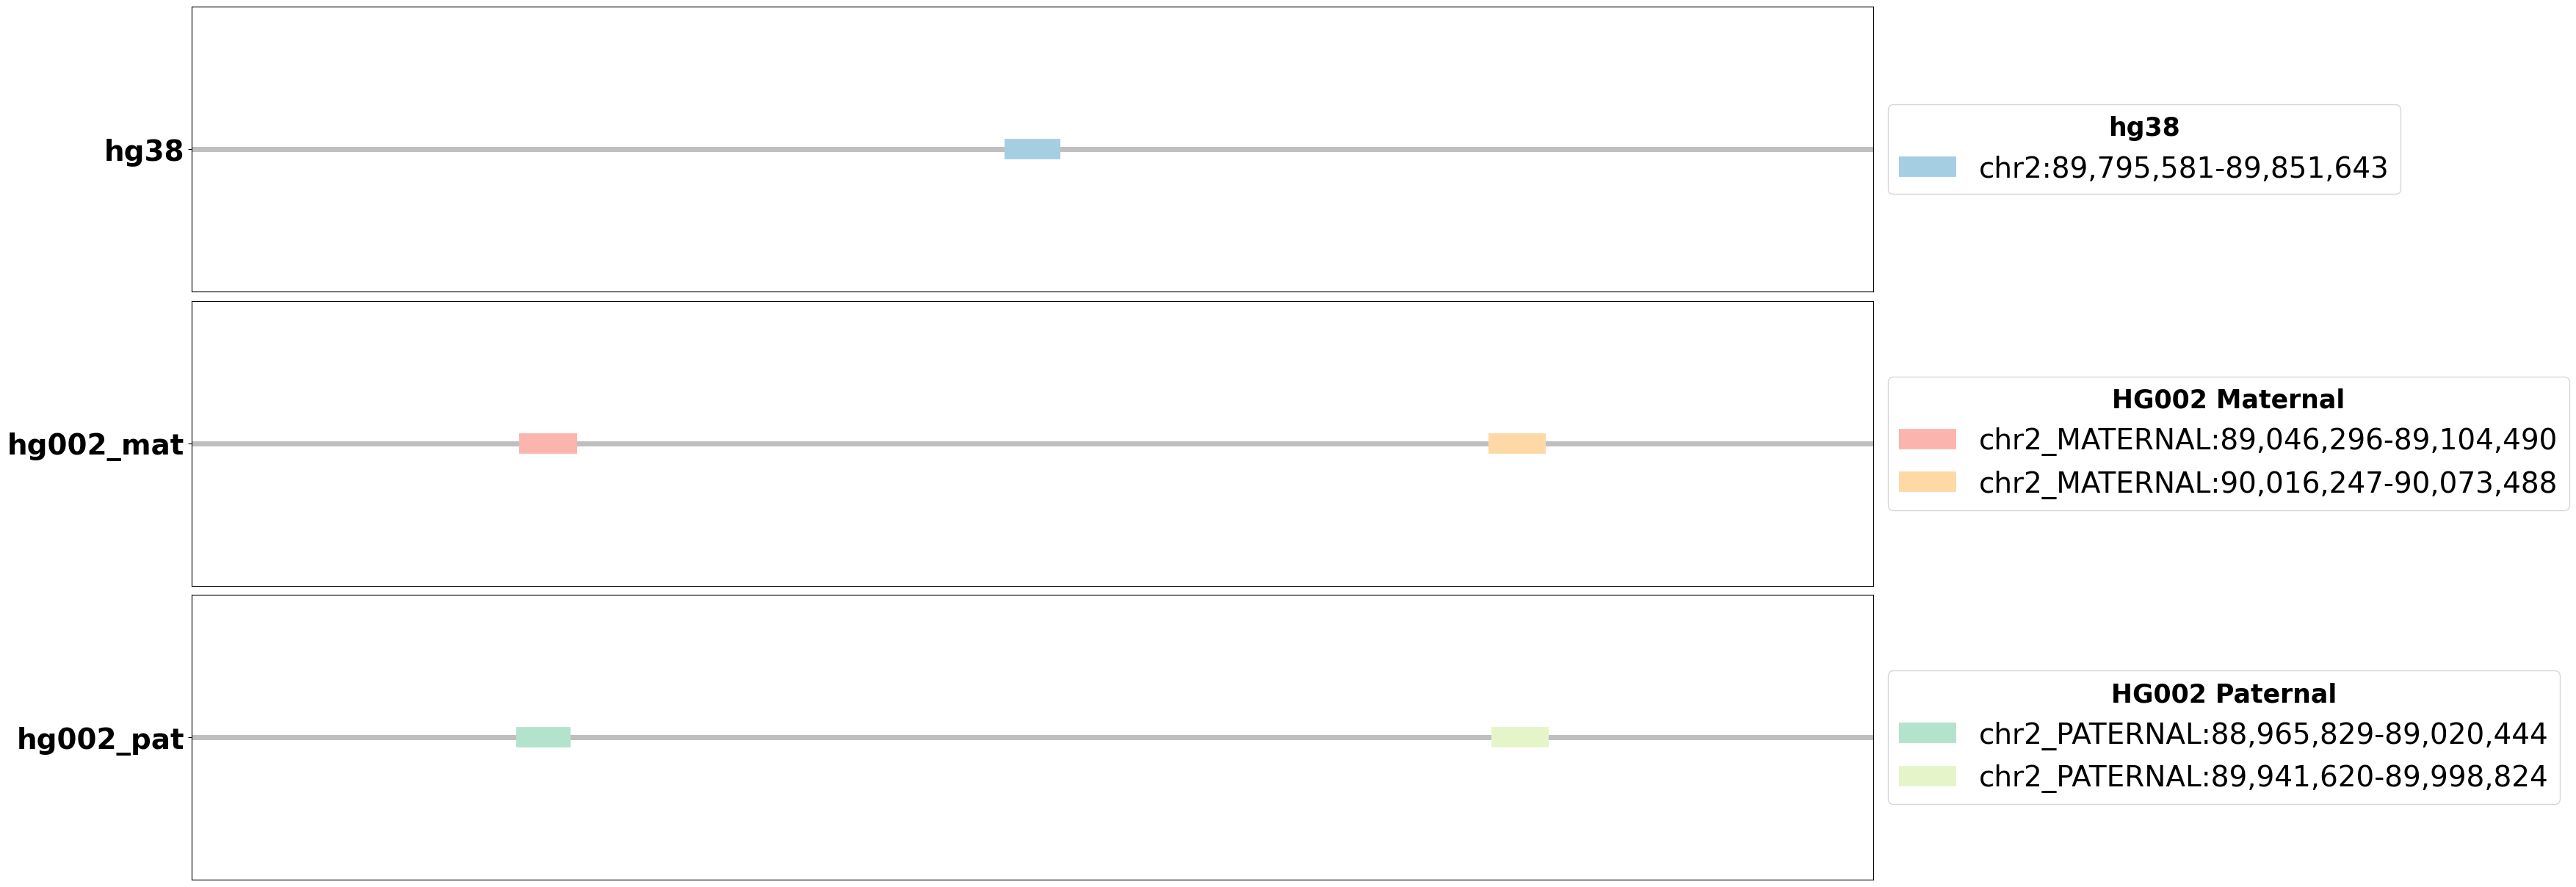

In [33]:
avu.PlotIntervals(['chr2:89795581-89851643'],
 ['chr2_MATERNAL:90016247-90073488',
  'chr2_PATERNAL:89941620-89998824',
  'chr2_PATERNAL:88965829-89020444',
  'chr2_MATERNAL:89046296-89104490']).plot_intervals_comparison(flanking=False, ratio=30)

In [34]:
# How many times did the DEL sequence occur in HG2-T2T?
v.align_interval("chr2:89815283-89817768", ReferenceLocations.hg38, hg38, hg002t2t) 

(['chr2:89815282-89817768'],
 ['chr2_PATERNAL:89961304-89963795', 'chr2_MATERNAL:90035956-90038437'])

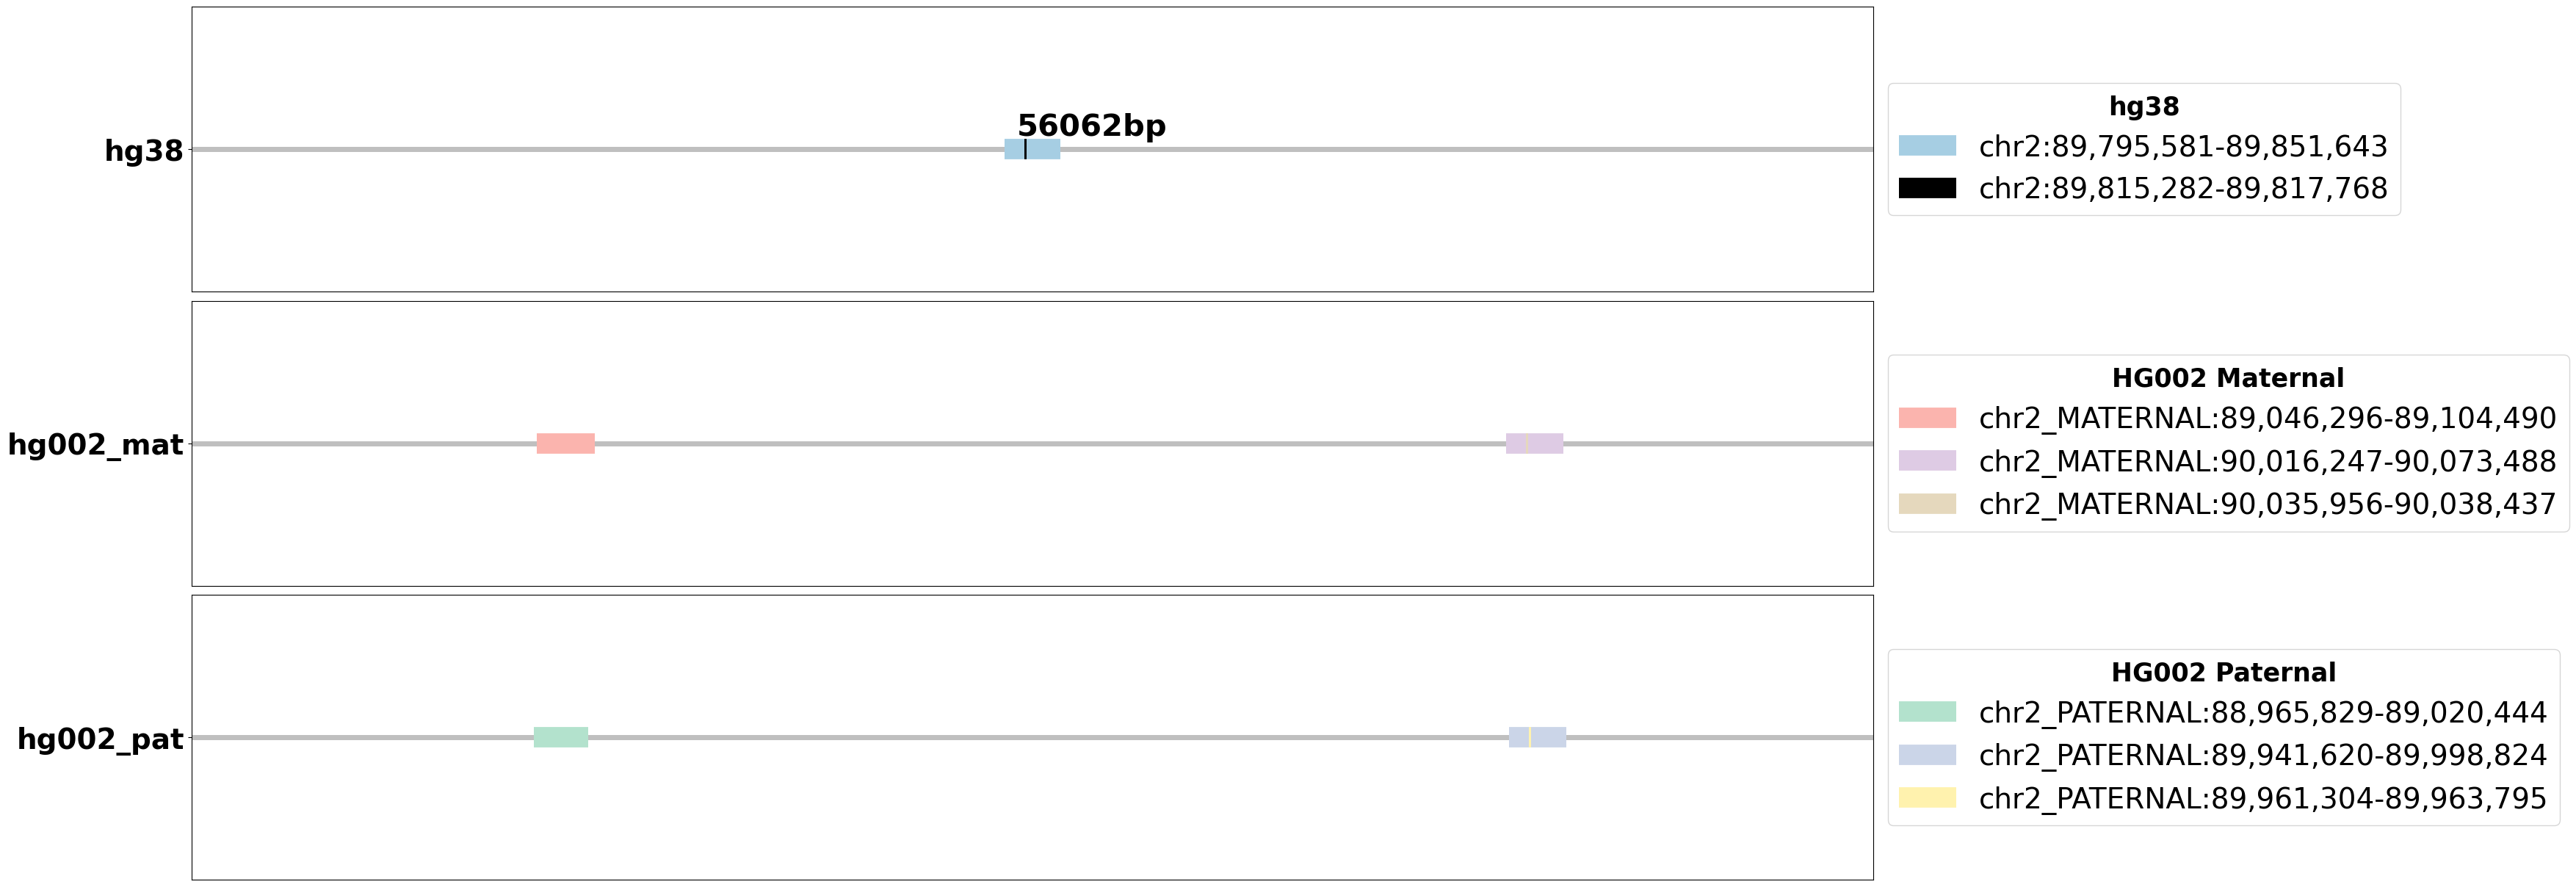

In [35]:
avu.PlotIntervals(['chr2:89795581-89851643','chr2:89815282-89817768'],
 ['chr2_MATERNAL:90016247-90073488',
  'chr2_PATERNAL:89941620-89998824',
  'chr2_PATERNAL:88965829-89020444',
  'chr2_MATERNAL:89046296-89104490',
  'chr2_PATERNAL:89961304-89963795',
  'chr2_MATERNAL:90035956-90038437']).plot_intervals_comparison(flanking=False, ratio=30)

# Overlapping Events Intervals

In [81]:
overlapping_del_dict = ip.find_overlapping_intervals(DEL_pass_intervals)
overlapping_dup_dict = ip.find_overlapping_intervals(DUP_pass_intervals)
print('Number of overlapping DEL events:',len(overlapping_del_dict))    
print('Number of overlapping DUP events:',len(overlapping_dup_dict))    

Number of overlapping DEL events: 63
Number of overlapping DUP events: 13


In [75]:
# Check a DEL within DEL case
v.get_flanking_pairs("chr1:1934990-1935584", ReferenceLocations.hg38, hg38, hg002t2t)

chr1:1934489-1934989 chr1:1935584-1936084 594
chr1_MATERNAL:1371773-1372273 chr1_MATERNAL:1372868-1373370 594


{'ref_flank': [('chr1:1934489-1934989', 'chr1:1935584-1936084', 594)],
 'truth_flank': [('chr1_MATERNAL:1371773-1372273',
   'chr1_MATERNAL:1372868-1373370',
   594)]}

# Test DUP within DUP function

In [ ]:
## Build function to evaluate DEL within DUP cases
# TODO: 1. Evaluate if the DUP is a real DUP DONE
# TODO: 2. Check the location of the DEL sequence in HG2-T2T DONE
# TODO: 3. Check if the DEL sequence is within the DUP copies in HG2-T2T DONE
# TODO: 4. Construct right and left flanking regions to evaluate the DEL DONE
# TODO: 5. Check distance between the flanking regions DONE
# TODO: 6. Plot the alignment of the flanking regions DONE
# TODO: 7. Make it into a function DONE

In [259]:
importlib.reload(v)
importlib.reload(avu)

<module 'T2T_ACE.alignment_visualization_utilities' from '/Users/gaoyueya/Documents/GitHub/T2T-ACE/T2T_ACE/alignment_visualization_utilities.py'>

chr2:89795582-89851643 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:4

DEL copies in hg38:1
DEL copies in HG2:2

DEL in DUP copy: chr2_MATERNAL:90035956-90038437 chr2_MATERNAL:90016247-90073488
DEL in DUP copy: chr2_PATERNAL:89961304-89963795 chr2_PATERNAL:89941620-89998824

Left flanking region: chr2:89795582-89815282 HG2 Copies: 4
DEL length: 2486 bp
Right flanking region: chr2:89817768-89851643 HG2 Copies: 4


* chr2_PATERNAL:89000725-89020444 chr2_PATERNAL:88965829-89000724 0


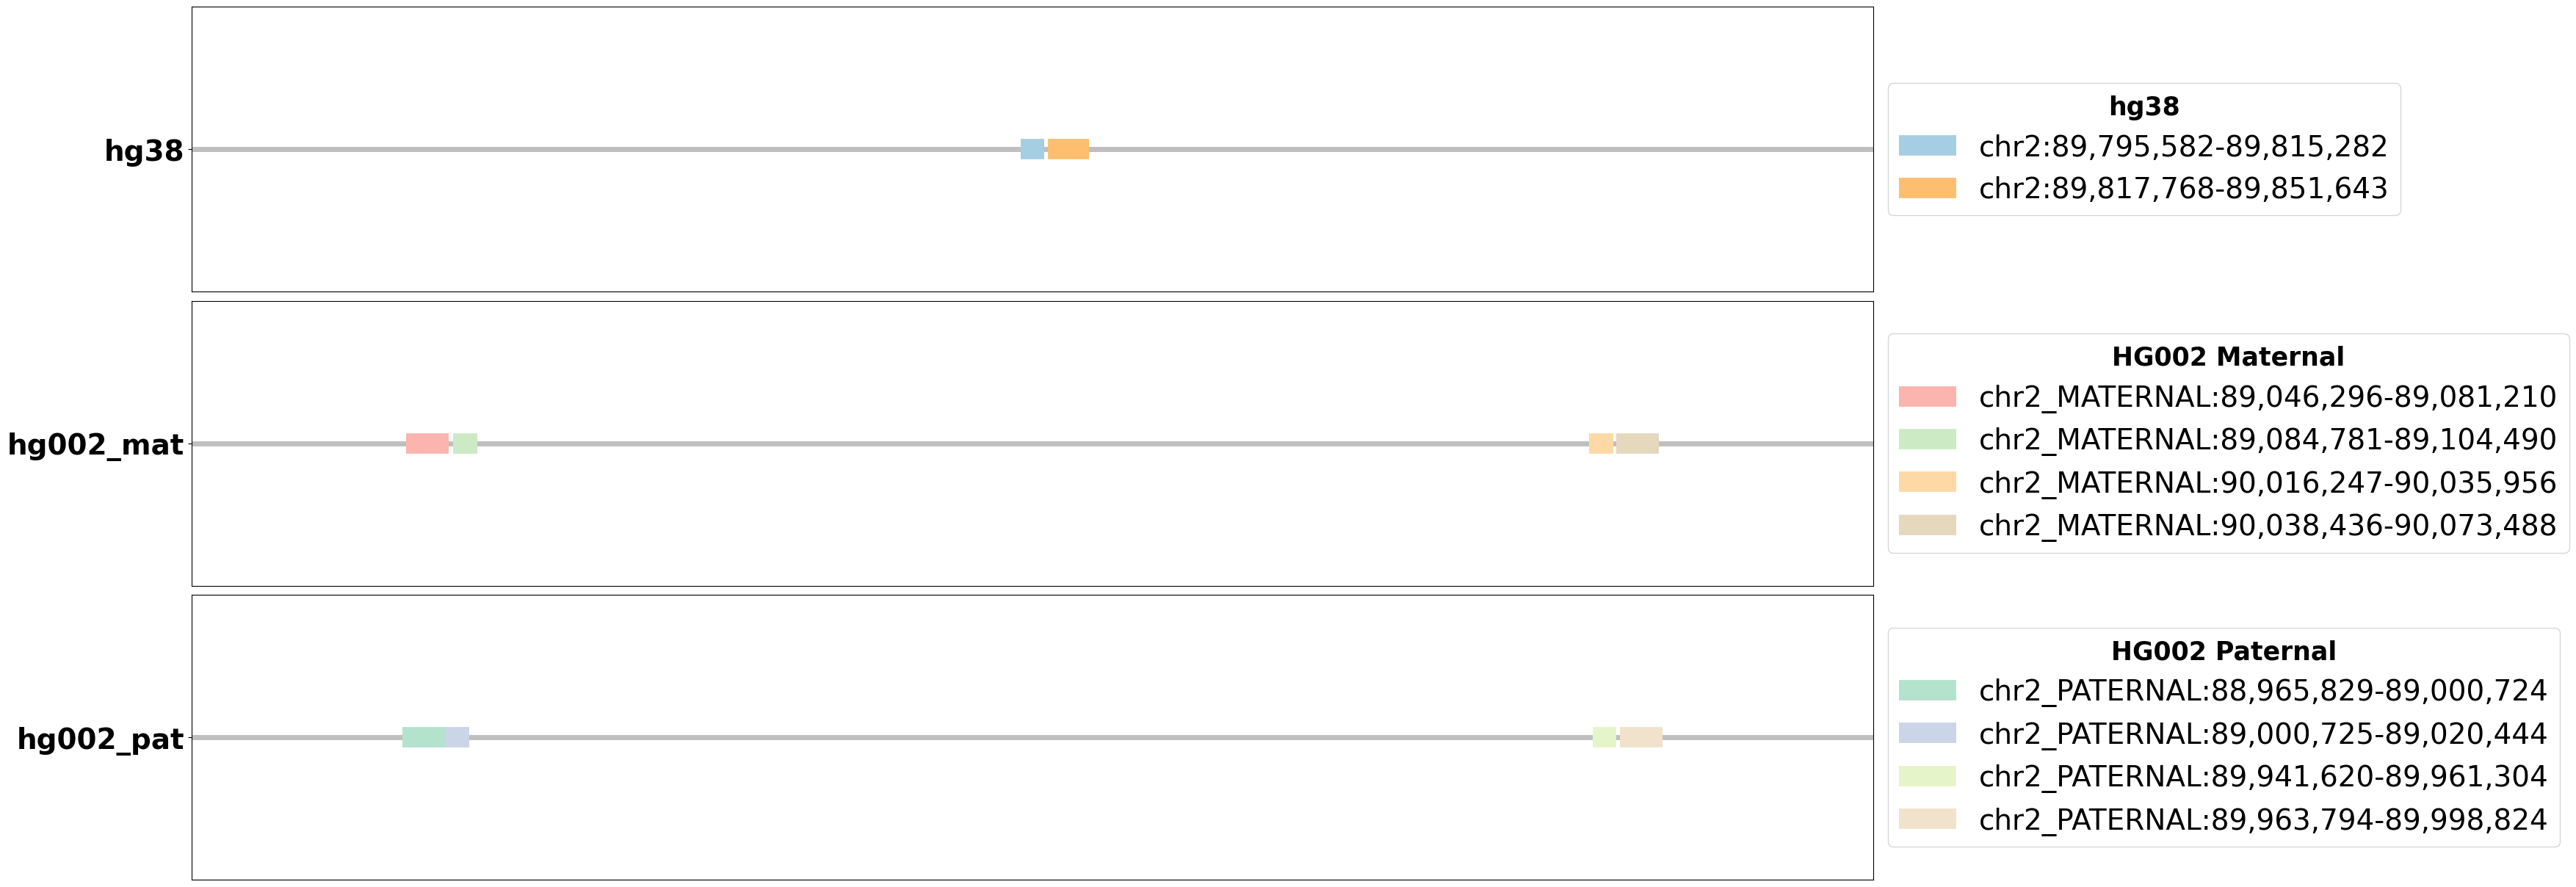

In [256]:
# Test the eval_del_in_dup function
dup_interval = "chr2:89795582-89851643"
del_interval = "chr2:89815283-89817768"

try:
    v.eval_del_in_dup(del_interval,dup_interval, ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=70)
except SystemExit as e:
    print(e)

In [226]:
# Test Error handling of the eval_del_in_dup function
try:
    v.eval_del_in_dup(dup_interval,del_interval, ReferenceLocations.hg38, hg38, hg002t2t)
except SystemExit as e:
    print(e)

DEL interval chr2:89795582-89851643 not within DUP interval chr2:89815283-89817768


In [271]:
# The eval_del_in_dup function is working
# Test the function on the DUP within DEL cases

for index,del_in_dup_pair in enumerate(del_within_dup_list):
    if len(v.align_interval(del_in_dup_pair[1], ReferenceLocations.hg38, hg38, hg002t2t)[1]) <= 2:
        print(f'{index}.DEL within DUP: {del_in_dup_pair[0]}, {del_in_dup_pair[1]}')
        print('Complex DUP requires further investigation')
    else:
        print('--------------------------------------------')
        print(f'{index}.DEL within DUP: {del_in_dup_pair[0]}, {del_in_dup_pair[1]}')
        v.eval_del_in_dup(del_in_dup_pair[0],del_in_dup_pair[1], ReferenceLocations.hg38, hg38, hg002t2t)
        print('--------------------------------------------')

--------------------------------------------
0.DEL within DUP: chr1:13235347-13240700, chr1:13225212-13247040
chr1:13225212-13247040 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:3

DEL in DUP copy: chr1_PATERNAL:12625265-12630588 chr1_PATERNAL:12618932-12640735
DEL in DUP copy: chr1_MATERNAL:12661062-12666390 chr1_MATERNAL:12654730-12676537
DEL in DUP copy: chr1_MATERNAL:12878375-12883746 chr1_MATERNAL:12868220-12890084

Left flanking region: chr1:13225212-13235346; HG2 Copies: 4
DEL length: 5354 bp
Right flanking region: chr1:13240700-13247040; HG2 Copies: 4


* chr1_PATERNAL:12789954-12800106 chr1_PATERNAL:12800107-12806396 0
--------------------------------------------
--------------------------------------------
1.DEL within DUP: chr2:89815283-89817768, chr2:89795582-89851643
chr2:89795582-89851643 is a real DUP. It has 4 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38

chr17:46135409-46292238 is a real DUP. It has 3 copy(ies) in HG2 and 1 copy(ies) in hg38

DUP copies in hg38:1
DUP copies in HG2:3

DEL copies in hg38:1
DEL copies in HG2:5

DEL in DUP copy: chr17_MATERNAL:46911623-46912344 chr17_MATERNAL:46809518-46966695

Left flanking region: chr17:46135409-46237500; HG2 Copies: 3
DEL length: 725 bp
Right flanking region: chr17:46238225-46292238; HG2 Copies: 2


* chr17_PATERNAL:47165640-47267578 chr17_PATERNAL:47110667-47165639 0


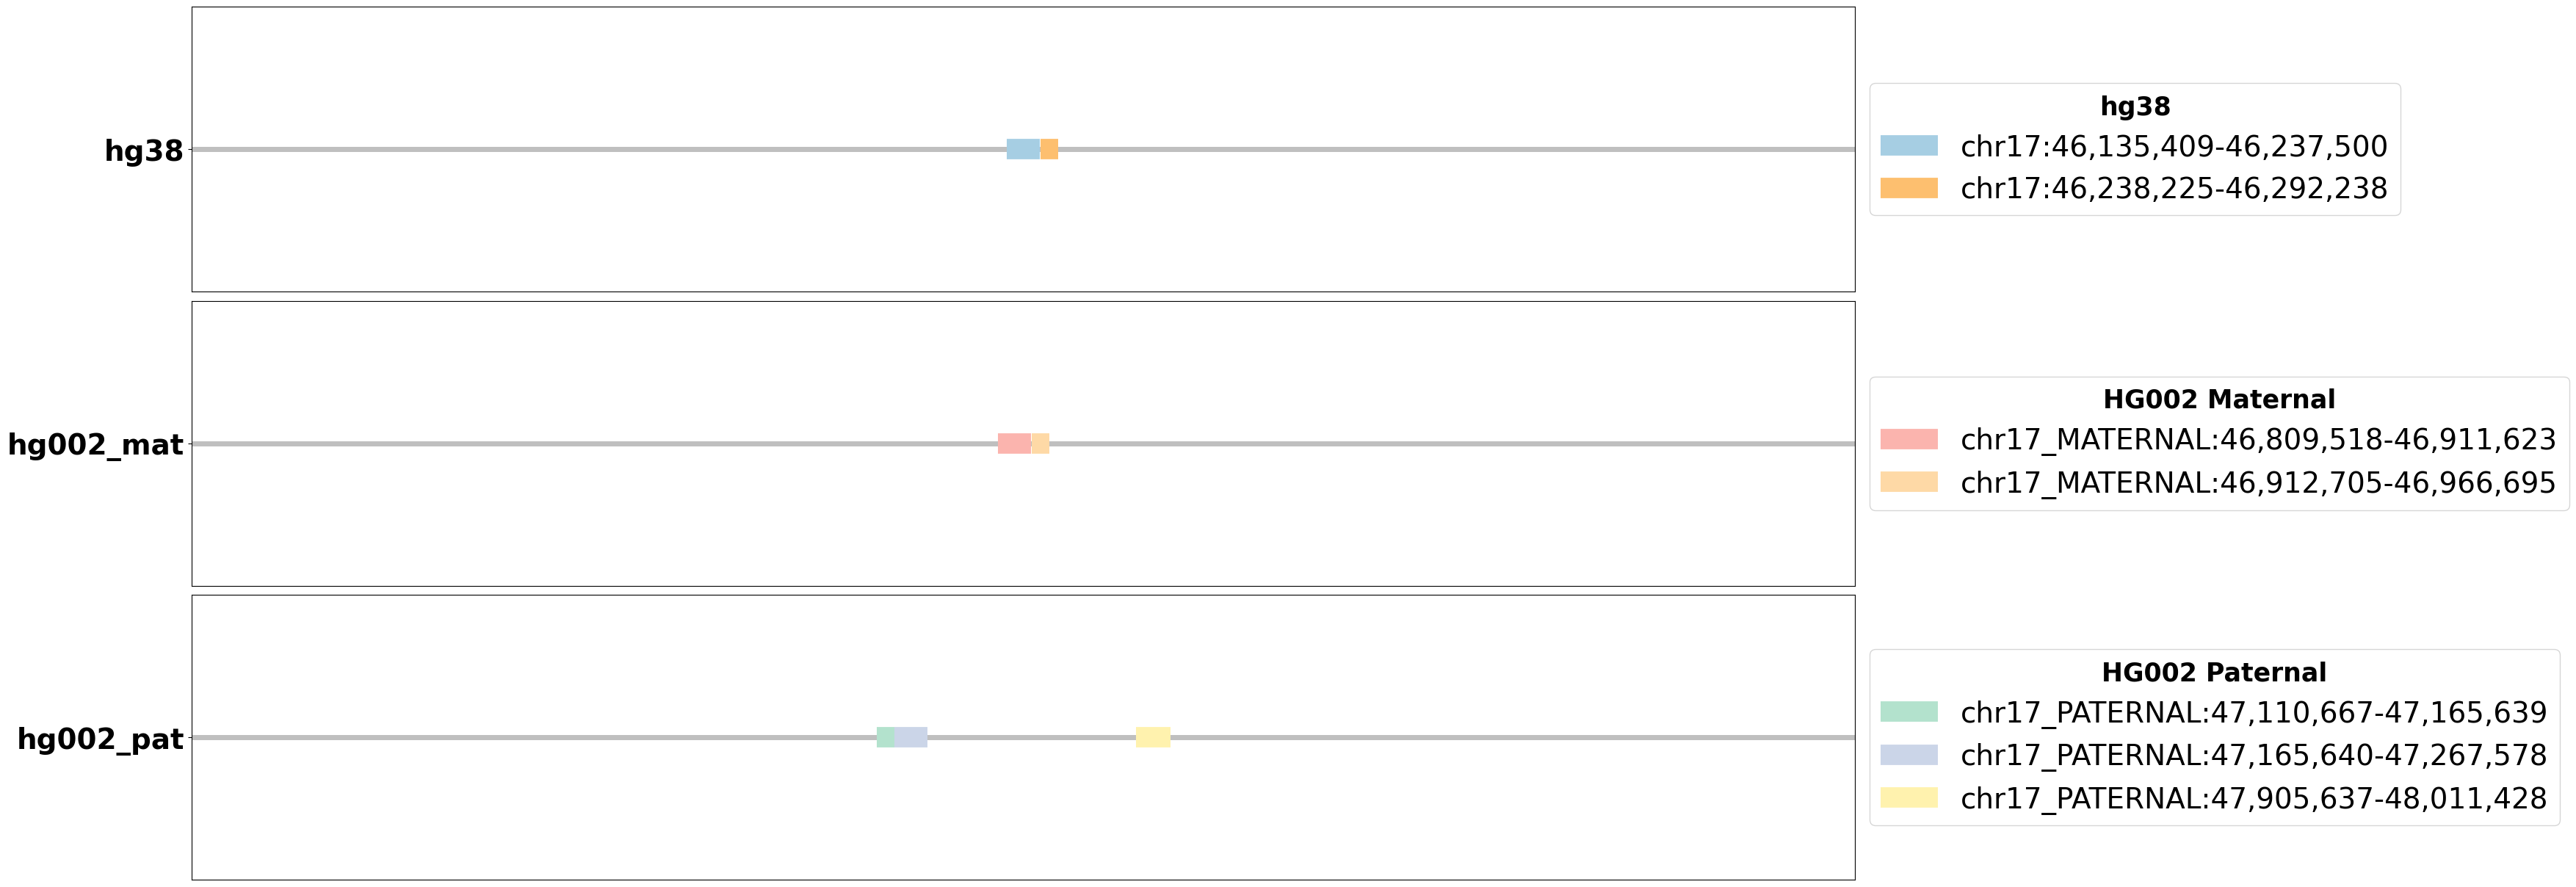

In [260]:
# The right flanking region didn't align to Paternal
# Requires further investigation
v.eval_del_in_dup(del_within_dup_list[9][0],del_within_dup_list[9][1], ReferenceLocations.hg38, hg38, hg002t2t, plot=True, plot_ratio=50,save_plot=True)